In [1]:
# add parent dir to sys.path so we can import from repo base
import os; import sys; sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))

In [2]:
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from script.dataset import get_data, get_id_col, cols_emg, cols_emg_cal
from script.visualization import pretty_hm, pretty_str, savefig_pdf

In [3]:
X, y = get_data(simplify=True)
X = X.groupby('id').mean().reset_index()
hold = y.reset_index()['hold']
hold_cats = pd.Categorical(y).categories
person = get_id_col(X, 1)
person_cats = pd.Categorical(person).categories

Distributions of EMG_0


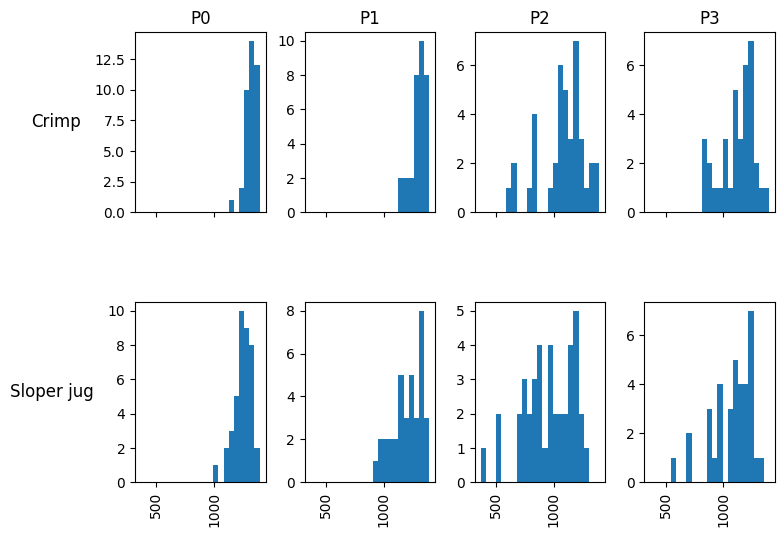

Distributions of EMG_0_cal


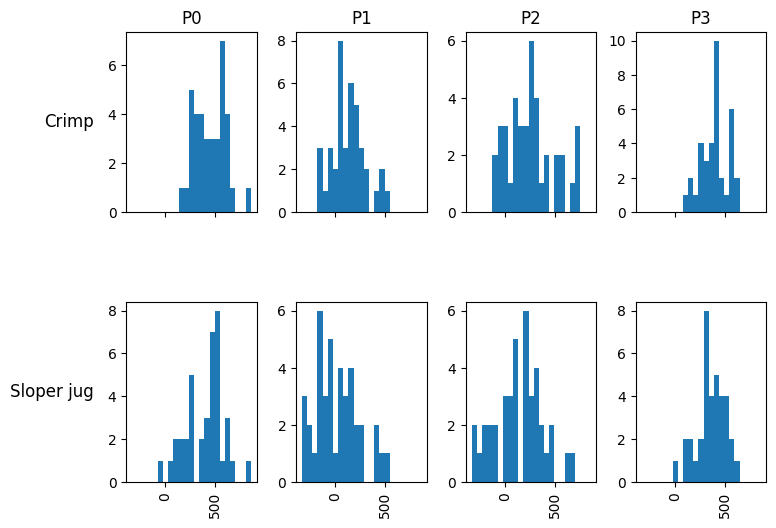

In [4]:
def plot_example_dists(example: str = 'EMG_0', bin_count = 25):
    bins = np.arange(X[example].min(), X[example].max(), (X[example].max() - X[example].min()) / (bin_count - 1))
    
    axes = X[example].hist(
        by=[hold, person],
        bins=bins, layout=(len(hold_cats), len(person_cats)),
        sharex=True, figsize=(8,6))
    
    for ax, (h, p) in zip(axes.flatten(), [(h, p) for h in hold_cats for p in person_cats]):
        row, col = list(hold_cats).index(h), list(person_cats).index(p)
        ax.set_title(pretty_str(p) if row == 0 else '', fontsize=12)
        if col == 0:
            ax.annotate(pretty_str(h), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 2, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        ha='right', va='center', fontsize=12, rotation=0)
    print(f'Distributions of {example}')
    savefig_pdf(f'distributions-{example}')
    plt.show()

sensor = 0
plot_example_dists(f'EMG_{sensor}')
plot_example_dists(f'EMG_{sensor}_cal')

In [5]:
hpcs = np.array(np.meshgrid(hold_cats, person_cats)).T.reshape((len(hold_cats) * len(person_cats), 2))

alpha = 0.95
threshold = (1 - alpha) / binom(len(hpcs) * 16, 2)
print('Bonferroni-corrected rejection threshold:')
print(f'  p < {threshold:.10f}  ⇔  -log(p) > {-np.log(threshold):.2f}')

Bonferroni-corrected rejection threshold:
  p < 0.0000061516  ⇔  -log(p) > 12.00


In [6]:
results = np.zeros((len(hpcs), len(hpcs)))
desired_rejection = np.zeros((len(hpcs), len(hpcs)))
for i, (hold1, name1) in enumerate(hpcs):
    for j, (hold2, name2) in enumerate(hpcs):
        for h in range(8):
            if i <= j: continue
            p_abs = mannwhitneyu(
                X[f'EMG_{h}'][(hold == hold1) & (person == name1)],
                X[f'EMG_{h}'][(hold == hold2) & (person == name2)]).pvalue
            p_rel = mannwhitneyu(
                X[f'EMG_{h}_cal'][(hold == hold1) & (person == name1)],
                X[f'EMG_{h}_cal'][(hold == hold2) & (person == name2)]).pvalue
            
            results[i, j] += sum(p < threshold for p in [p_abs, p_rel])
            desired_rejection[i, j] += 0 if hold1 == hold2 else 2

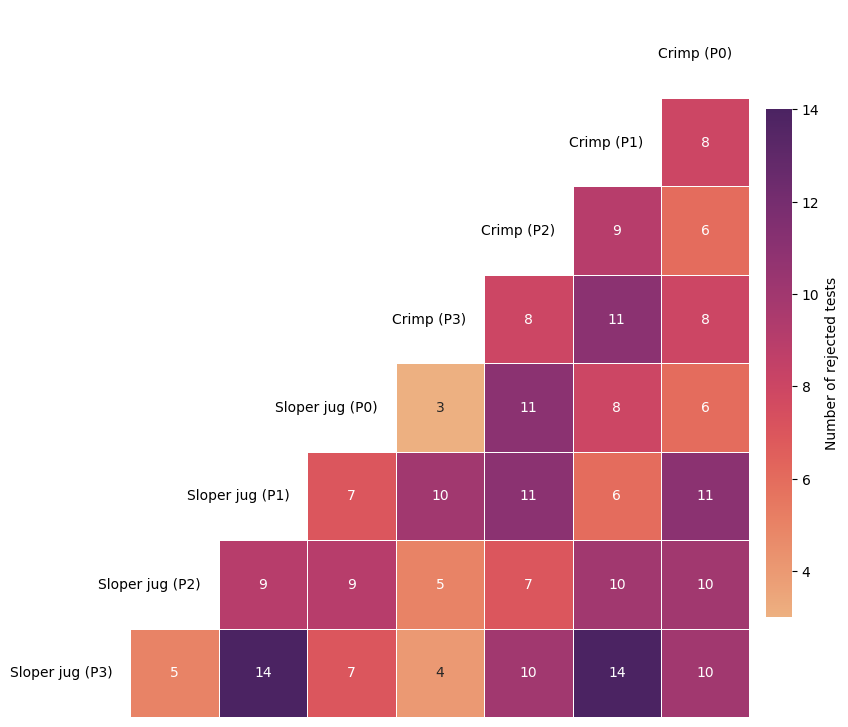

In [7]:
plt.subplots(figsize=(11, 11))
labels = [f'{pretty_str(hold)} ({pretty_str(name)})' for hold, name in hpcs]
pretty_hm(results, labels, transform=None, legend='Number of rejected tests')
savefig_pdf('pairwise-mw')

Desired rejection pattern where 1 is rejection and 0 is fail to reject


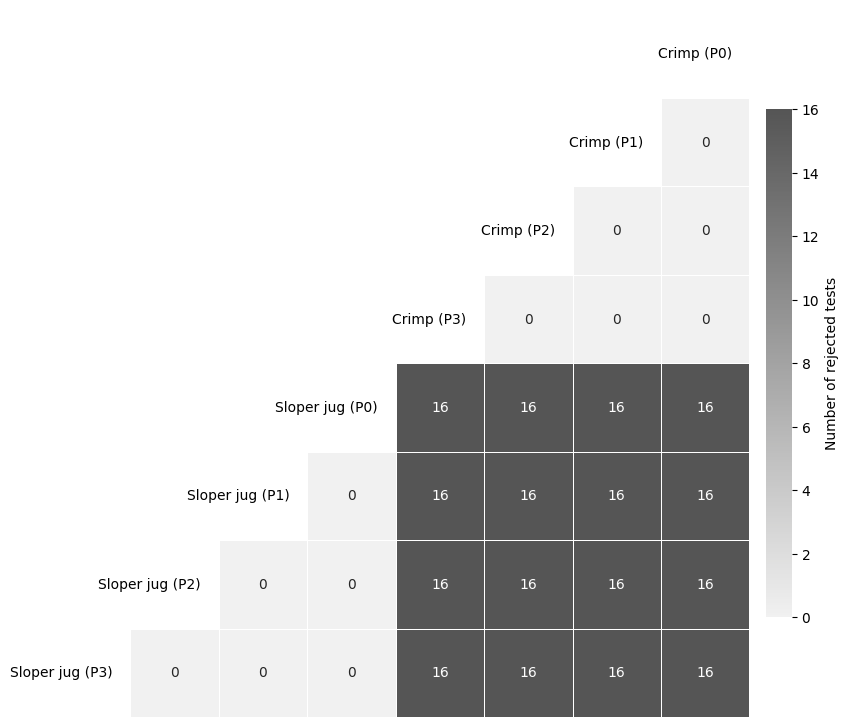

In [8]:
plt.subplots(figsize=(11, 11))
pretty_hm(desired_rejection, labels, legend='Number of rejected tests', transform=None, cmap=sns.color_palette("light:#555", as_cmap=True))
savefig_pdf('desired-rejection')
print('Desired rejection pattern where 1 is rejection and 0 is fail to reject')